# COVID-19 US Daily Stats by State
    data from 'https://covidtracking.com/api/states/daily'

In [74]:
import pandas as pd 
import numpy as np
import datetime
import json
import urllib
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

covid_url = 'https://covidtracking.com/api/states/daily'

def inttodate(date_in,mode='date'):
    #yyyymmdd
    date_int = int(date_in)
    year = int(np.floor(date_int/10000))
    month = int(np.floor((date_int - year*10000)/100))
    day = int(date_int - year*10000 - month*100)
    
    if mode =='date':
        date = datetime.date(year,month,day)
    elif mode == ' datetime':
        date = datetime.datetime(year,month,day,0,0,0)
    elif mode == 'np.datetime64':
        date=np.datetime64(datetime.datetime(year,month,day))
    return date

def covidJsonToDf(json_in,sma_window=5,verbose=False):
    data = json_in.copy()
    df = []
    for i in range(len(data)):
        this_row = []
        if i==0:
            cols = []
            for key in data[0]:
                cols.append(key)
            if verbose:
                print(cols)
        if len(data[i])!=len(cols):
            if verbose:
                print("columns do not match: ",data[i]['state']," ",data[i]['date'])
        for key in cols:
            try:
                this_row.append(data[i][key])
            except:
                this_row.append(np.nan)
        df.append(this_row)
    df=pd.DataFrame(df)
    df.columns=list(cols)
    
    return df
    
def calcFields(df,sma_window=5,verbose=False):
    df['Date']=df['date'].apply(lambda d: inttodate(d))
    df['percentNewPositive']=df['positiveIncrease']/df['totalTestResultsIncrease']
    df['percentNewHospOfPositive']=df['hospitalizedIncrease']/df['positiveIncrease']
    df['percentNewHospOfTotal']=df['hospitalizedIncrease']/df['totalTestResultsIncrease']
    df['deathRate1']=df['death']/df['positive']
    df['deathRate2']=df['death']/df['hospitalizedCumulative']
    df=df.sort_values(by=['state','date'])
    
    df['SMA_newPositive_'+str(sma_window)] = df['positiveIncrease'].rolling(window=sma_window).mean()
    df['SMA_newHosp_'+str(sma_window)] = df['hospitalizedIncrease'].rolling(window=sma_window).mean()
    df['SMA_newDeath_'+str(sma_window)]  = df['deathIncrease'].rolling(window=sma_window).mean()
    df['SMA_testIncrease_'+str(sma_window)] = df['totalTestResultsIncrease'].rolling(window=sma_window).mean()
    df['SMA_percentNewPos_'+str(sma_window)] = df['percentNewPositive'].rolling(window=sma_window).mean()
    df['SMA_percentNewHosp_'+str(sma_window)] = df['percentNewHospOfPositive'].rolling(window=sma_window).mean()
    df['SMA_percentNewHospOfTotal_'+str(sma_window)] = df['percentNewHospOfTotal'].rolling(window=sma_window).mean()
    
    try: # requires Population which comes from an external dataset, I copied from Wikipedia I think
        df['positivePerMM']=df['positive']/df['Population']*1000000
        df['positiveIncreasePerMM']=df['positiveIncrease']/df['Population']*1000000
        df['hospitalizedIncreasePerMM']=df['hospitalizedIncrease']/df['Population']*1000000
        df['hospitalizedCumulativePerMM']=df['hospitalizedCumulative']/df['Population']*1000000
        df['hospitalizedCurrentlyPerMM']=df['hospitalizedCurrently']/df['Population']*1000000
        df['deathIncreasePerMM']=df['deathIncrease']/df['Population']*1000000
        df['deathPerMM']=df['death']/df['Population']*1000000
        df['totalTestResultsIncreasePerMM'] = df['totalTestResultsIncrease']/df['Population']*1000000
        
        df['SMA_positivePerMM_'+str(sma_window)] = df['positivePerMM'].rolling(window=sma_window).mean()
        df['SMA_positiveIncreasePerMM_'+str(sma_window)] = df['positiveIncreasePerMM'].rolling(window=sma_window).mean()
        df['SMA_hospitalizedIncreasePerMM_'+str(sma_window)]  = df['hospitalizedIncreasePerMM'].rolling(window=sma_window).mean()
        df['SMA_hospitalizedCumulativePerMM_'+str(sma_window)] = df['hospitalizedCumulativePerMM'].rolling(window=sma_window).mean()
        df['SMA_deathIncreasePerMM_'+str(sma_window)] = df['deathIncreasePerMM'].rolling(window=sma_window).mean()
        df['SMA_deathPerMM_'+str(sma_window)] = df['deathPerMM'].rolling(window=sma_window).mean()
        df['SMA_testIncreasePerMM_'+str(sma_window)] = df['totalTestResultsIncreasePerMM'].rolling(window=sma_window).mean()
        
    except:
        ()
        
    return df



print('-- setup and functions')

-- setup and functions


In [75]:
dfpop = pd.read_csv('~/Documents/COVID/us_state_population.csv')

response = urllib.request.urlopen(covid_url)
data = json.loads(response.read())

df = covidJsonToDf(data,verbose=False)
df=df.merge(dfpop,left_on='state',right_on='State',how='left')
df = calcFields(df)
df_ny = df[df['state']=='NY']

max_date = max(df['Date'])
df_today=df[df['Date']==max_date].reset_index(drop=True)
df_ny_today=df_ny[df_ny['Date']==max_date].reset_index(drop=True)
us_pnew = sum(df_today['positiveIncrease'])/sum(df_today['totalTestResultsIncrease'])

print('Data As Of: ',max_date)
print('US: new cases =',sum(df_today['positiveIncrease']),"  % Positive =",np.round(us_pnew*100,2))
print('NY: new cases = ',df_ny_today['positiveIncrease'][0],"  % Positive =",
      np.round(df_ny_today['percentNewPositive'][0]*100,2),"  % Hosp of Positive =",
      np.round(df_ny_today['percentNewHospOfPositive'][0]*100,2),"  % Hosp of Total =",
      np.round(df_ny_today['percentNewHospOfTotal'][0]*100,2),)



Data As Of:  2020-05-05
US: new cases = 22348.0   % Positive = 8.62
NY: new cases =  2239.0   % Positive = 10.37   % Hosp of Positive = 23.94   % Hosp of Total = 2.48


## NY Stats

Text(0.5, 1.0, 'NY COVID-19 Daily Deaths')

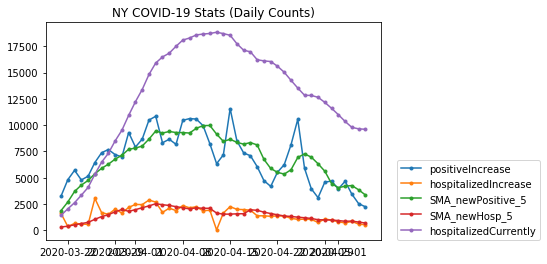

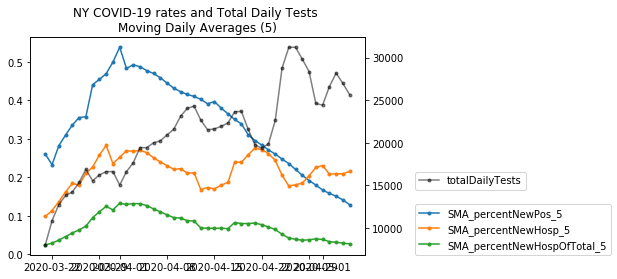

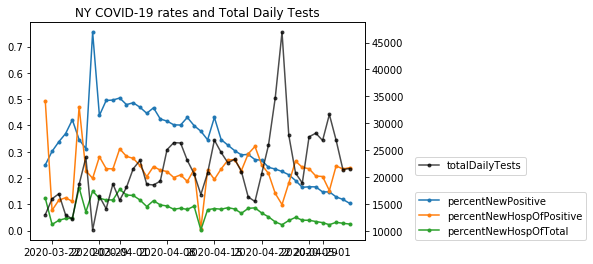

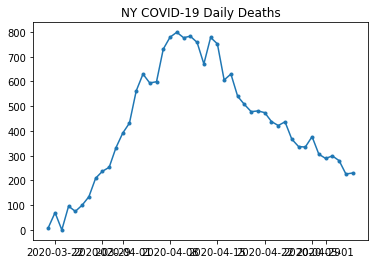

In [76]:
startdate=20200320

for field in ['positiveIncrease','hospitalizedIncrease','SMA_newPositive_5','SMA_newHosp_5','hospitalizedCurrently']:
#for field in ['totalTestResultsIncrease','positiveIncrease','negativeIncrease','hospitalizedIncrease']:
    df_filtered = df_ny[df_ny['date']>startdate]
    #plt.figure()
    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
plt.legend(loc=(1.05,0))
plt.title("NY COVID-19 Stats (Daily Counts)")
    #plt.title(field)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for field in ['SMA_percentNewPos_5','SMA_percentNewHosp_5','SMA_percentNewHospOfTotal_5']:
    ax1.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
ax2.plot(df_filtered['Date'],df_filtered['SMA_testIncrease_5'],'.-',color='black',label='totalDailyTests',alpha=.5)
ax1.legend(loc=(1.15,0))
ax2.legend(loc=(1.15,.3))
plt.title('NY COVID-19 rates and Total Daily Tests \nMoving Daily Averages (5)')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for field in ['percentNewPositive','percentNewHospOfPositive','percentNewHospOfTotal']:
    ax1.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
ax2.plot(df_filtered['Date'],df_filtered['totalTestResultsIncrease'],'.-',color='black',label='totalDailyTests',alpha=.7)

ax1.legend(loc=(1.15,0))
ax2.legend(loc=(1.15,.3))
plt.title('NY COVID-19 rates and Total Daily Tests')
    
plt.figure()
plt.plot(df_filtered['Date'],df_filtered['deathIncrease'],'.-')

plt.title('NY COVID-19 Daily Deaths')

In [77]:
df_ny_ts=df_ny[['positiveIncrease','hospitalizedIncrease','deathIncrease',
                'totalTestResultsIncrease','percentNewPositive','percentNewHospOfPositive','percentNewHospOfTotal']].transpose()
df_ny_ts.columns=list(df_ny['Date'])
df_ny_ts

,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05
positiveIncrease,NaN,16.000000,11.000000,43.0,29.0,37.0,31.0,43.0,0.0,205.000000,103.0,205.000000,221.0,750.000000,682.000000,1770.000000,2950.000000,3254.000000,4812.000000,5707.000000,4790.000000,5146.000000,6447.000000,7377.000000,7683.000000,7195.000000,6984.000000,9298.000000,7917.000000,8669.000000,10482.000000,10841.000000,8327.000000,8658.000000,8174.000000,10453.000000,10621.000000,10575.000000,9946.000000,8236.000000,6337.000000,7177.000000,11571.000000,8505.000000,7358.000000,7090.000000,6054.000000,4726.000000,4178.000000,5526.000000,6244.000000,8130.000000,10553.000000,5902.000000,3951.000000,3110.000000,4585.000000,4681.000000,3942.000000,4663.000000,3438.000000,2538.000000,2239.000000
hospitalizedIncrease,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1603.000000,371.000000,661.000000,599.000000,571.000000,3039.000000,1682.000000,1528.000000,2021.000000,1646.000000,2183.000000,2464.000000,2449.000000,2879.000000,2687.000000,1709.000000,2111.000000,1880.000000,2349.000000,2144.000000,2242.000000,1861.000000,1915.000000,43.000000,1649.000000,2253.000000,1996.000000,1973.000000,1917.000000,1384.000000,1379.000000,1338.000000,1381.000000,1358.000000,1149.000000,1045.000000,1067.000000,1044.000000,748.000000,1079.000000,972.000000,811.000000,710.000000,846.000000,595.000000,536.000000
deathIncrease,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.000000,4.0,0.000000,5.000000,0.000000,23.000000,9.000000,70.000000,0.000000,96.000000,75.000000,100.000000,134.000000,209.000000,237.000000,253.000000,332.000000,391.000000,432.000000,562.000000,630.000000,594.000000,599.000000,731.000000,779.000000,799.000000,777.000000,783.000000,758.000000,671.000000,778.000000,752.000000,606.000000,630.000000,540.000000,507.000000,478.000000,481.000000,474.000000,438.000000,422.000000,437.000000,367.000000,337.000000,335.000000,377.000000,306.000000,289.000000,299.000000,280.000000,226.000000,230.000000
totalTestResultsIncrease,NaN,44.000000,27.000000,43.0,29.0,37.0,31.0,43.0,0.0,2892.000000,103.0,1969.000000,221.0,1713.000000,7391.000000,7687.000000,10143.000000,13010.000000,15964.000000,16888.000000,12981.000000,12209.000000,18625.000000,23649.000000,10181.000000,16426.000000,14108.000000,18718.000000,15694.000000,18085.000000,21555.000000,23101.000000,18659.000000,18531.000000,19247.000000,25095.000000,26396.000000,26336.000000,23095.000000,20621.000000,16756.000000,20786.000000,26869.000000,24567.000000,22644.000000,23309.000000,21023.000000,16306.000000,15464.000000,20657.000000,25938.000000,34736.000000,46912.000000,27782.000000,20745.000000,18899.000000,27487.000000,28155.000000,26802.000000,31633.000000,26840.000000,21399.000000,21589.000000
percentNewPositive,NaN,0.363636,0.407407,1.0,1.0,1.0,1.0,1.0,NaN,0.070885,1.0,0.104114,1.0,0.437828,0.092274,0.230259,0.290841,0.250115,0.301428,0.337932,0.369001,0.421492,0.346148,0.311937,0.754641,0.438025,0.495038,0.496741,0.504460,0.479348,0.486291,0.469287,0.446273,0.467217,0.424690,0.416537,0.402372,0.401542,0.430656,0.399399,0.378193,0.345280,0.430645,0.346196,0.324943,0.304174,0.287970,0.289832,0.270176,0.267512,0.240728,0.234051,0.224953,0.212440,0.190456,0.164559,0.166806,0.166258,0.147079,0.147409,0.128092,0.118604,0.103710
perce

## US Exclusing NYC

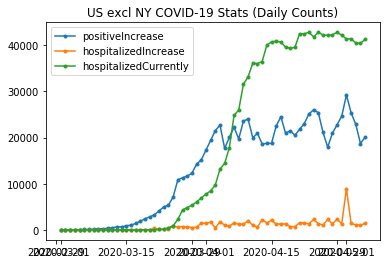

In [78]:
df_tmp = df[df['state']!='NY']
df_tmp = df_tmp.groupby('Date').sum().reset_index(drop=False)
startdate=20200317
df_filtered = df_tmp[df_tmp['date']>startdate]
df_filtered = df_filtered.fillna(0)
if len(df_filtered)<1:
    print("No Data for: "+state) 

plt.figure()
for field in ['positiveIncrease','hospitalizedIncrease','hospitalizedCurrently']:
#for field in ['totalTestResultsIncrease','positiveIncrease','negativeIncrease','hospitalizedIncrease']:
    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
    #plt.legend()
    plt.title("US excl NY COVID-19 Stats (Daily Counts)")
plt.legend()

## Worst n States: Timeseries

In [79]:
n=10

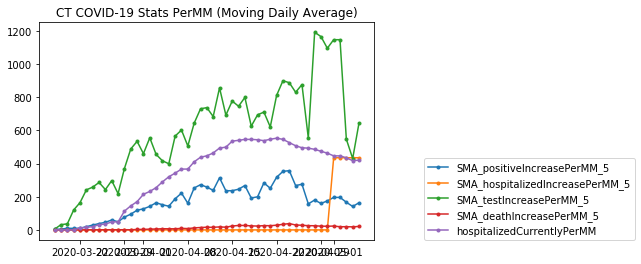

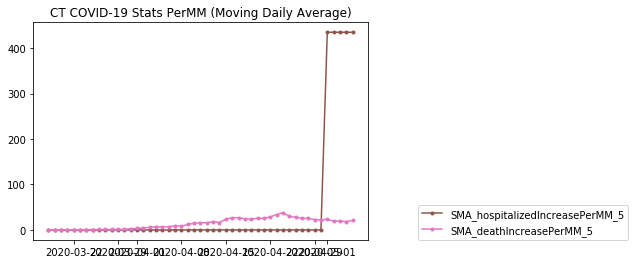

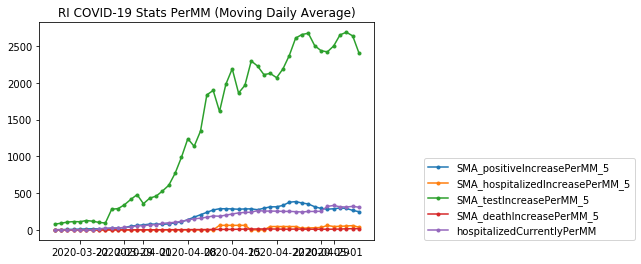

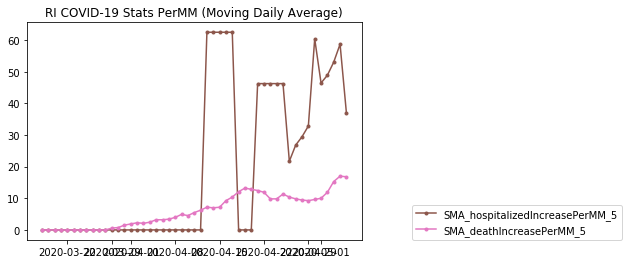

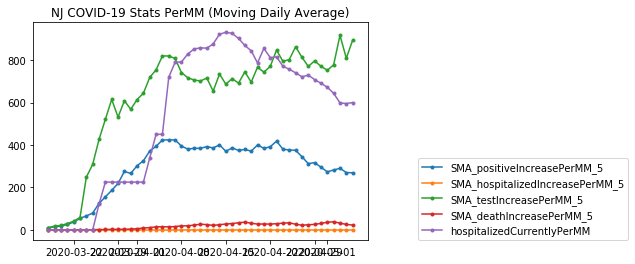

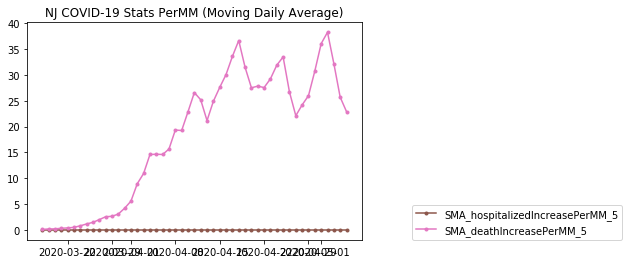

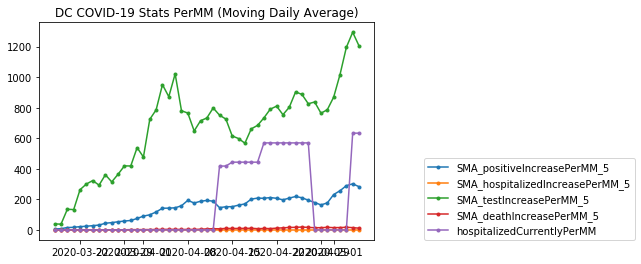

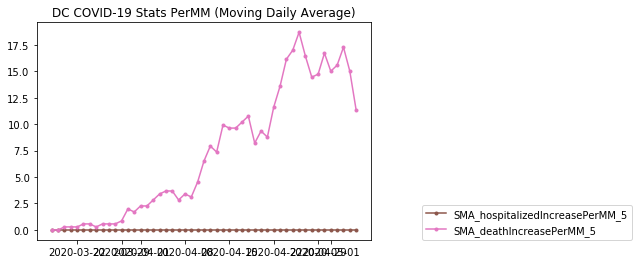

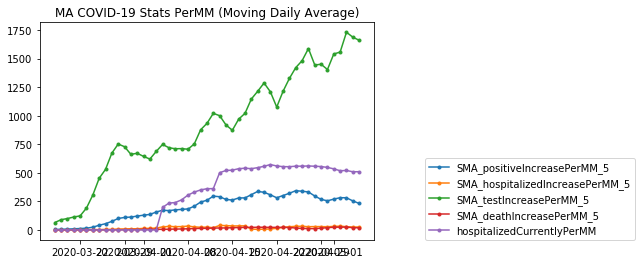

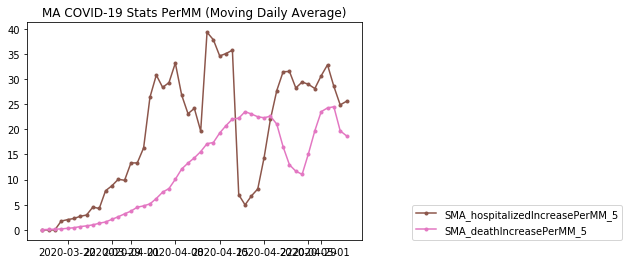

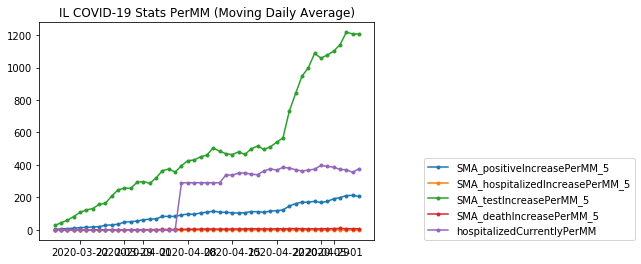

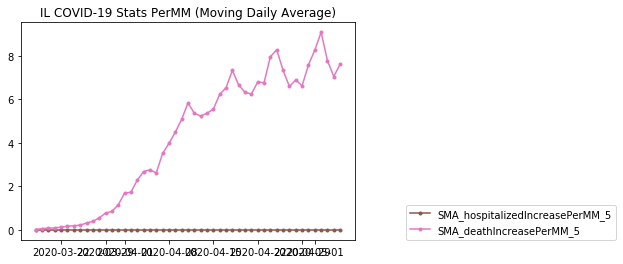

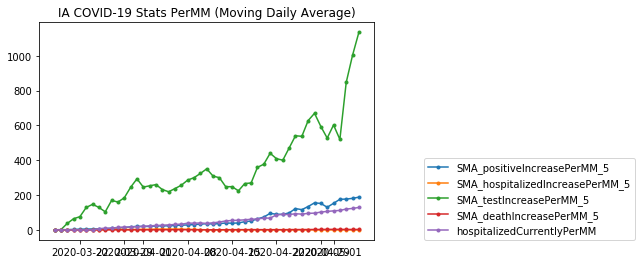

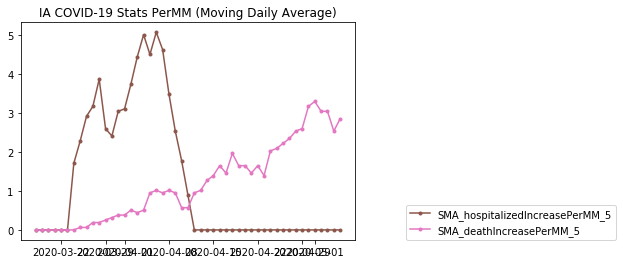

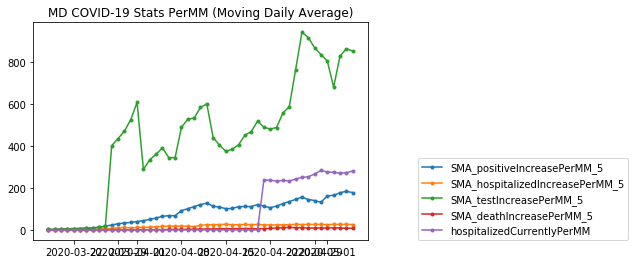

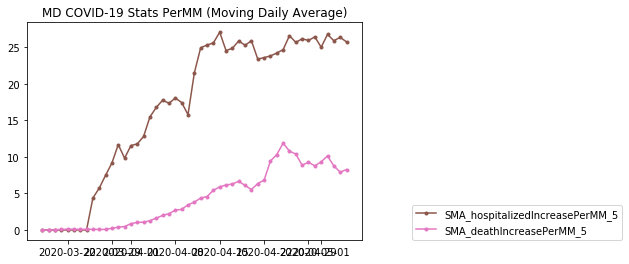

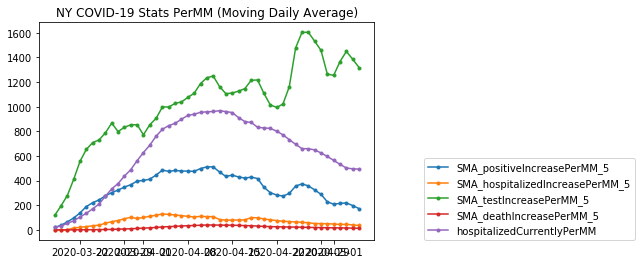

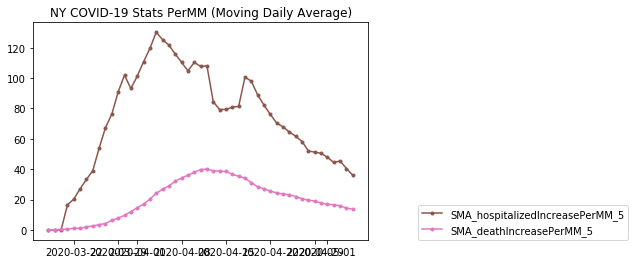

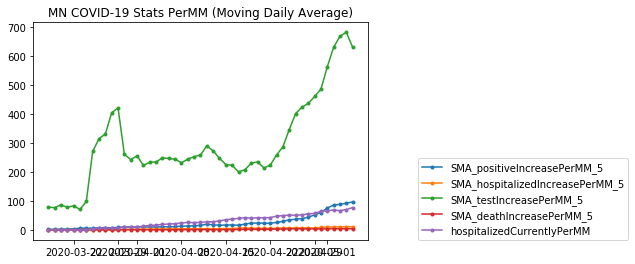

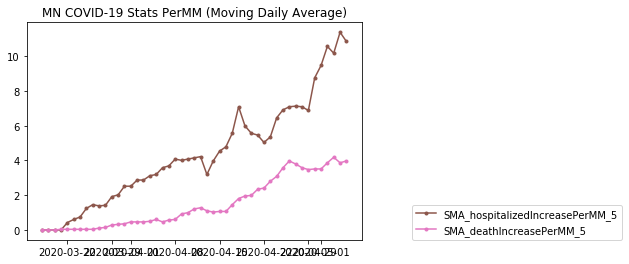

In [84]:
#mpl.style.use('default')

state_order=df_today.sort_values(by='positiveIncreasePerMM',ascending=False)['state']
i=1
for state in state_order:
    try:
        df_tmp = df[df['state']==state]
        startdate=20200317
        df_filtered = df_tmp[df_tmp['date']>startdate]
        df_filtered = df_filtered.fillna(0)
        if len(df_filtered)<1:
            print("No Data for: "+state) 
            continue

        plt.figure()
        #for field in ['SMA_testIncrease_5','SMA_newPositive_5','SMA_newHosp_5','SMA_newDeath_5']:
        #    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
        #plt.legend()
        #plt.title(state+" COVID-19 Stats (Moving Daily Average)")

            
        #fig, ax1 = plt.subplots()
        #ax2 = ax1.twinx()
        
        ci=0
        for field in ['SMA_positiveIncreasePerMM_5','SMA_hospitalizedIncreasePerMM_5','SMA_testIncreasePerMM_5','SMA_deathIncreasePerMM_5','hospitalizedCurrentlyPerMM']:
            plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field,color='C'+str(ci))
            ci+=1
            
        plt.legend(loc=(1.15,0))
        plt.title(state+" COVID-19 Stats PerMM (Moving Daily Average)")
        
        plt.figure()
        for field in ['SMA_hospitalizedIncreasePerMM_5','SMA_deathIncreasePerMM_5']:
            plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field,color='C'+str(ci))
            ci+=1
            
        plt.legend(loc=(1.15,0))
        plt.title(state+" COVID-19 Stats PerMM (Moving Daily Average)")
        
        #plt.figure()
        #for field in ['percentNewPositive','percentNewHospOfPositive','percentNewHospOfTotal']:
        #    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
        #    plt.title(state+' COVID-19 rates')
        #    plt.legend()

    except:
        print("ERROR: "+state) 
    
    i+=1
    if i>n:
        break

## Worst 10 States (PerMM)
    Total Positive, New Positive Today, Total Deaths

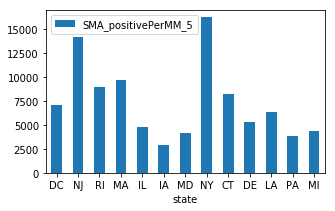

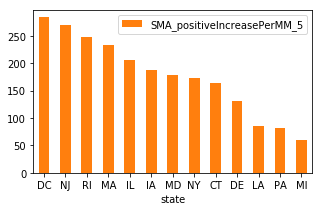

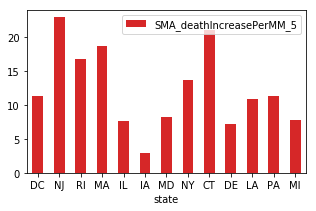

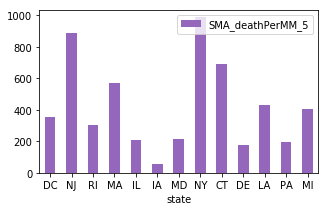

In [81]:
states_total = list(df_today.sort_values(by='SMA_positivePerMM_5',ascending=False).head(10)['state'])
states_inc = list(df_today.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).head(10)['state'])
states_death = list(df_today.sort_values(by='SMA_deathIncreasePerMM_5',ascending=False).head(10)['state'])
states_watch = states_total + states_inc + states_death

df_today_w = df_today[df_today['state'].apply(lambda s: s in states_watch)]

df_today_w.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).plot.bar(figsize=(5,3),x='state',y='SMA_positivePerMM_5',rot=0,color='C0')
df_today_w.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).plot.bar(figsize=(5,3),x='state',y='SMA_positiveIncreasePerMM_5',rot=0,color='C1')
#df_today.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).head(10).plot.bar(figsize=(5,3),x='state',y='hospitalizedCurrentlyPerMM',rot=0,color='C2')
df_today_w.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).plot.bar(figsize=(5,3),x='state',y='SMA_deathIncreasePerMM_5',rot=0,color='C3')
df_today_w.sort_values(by='SMA_positiveIncreasePerMM_5',ascending=False).plot.bar(figsize=(5,3),x='state',y='SMA_deathPerMM_5',rot=0,color='C4')

# All States - PerMM

Text(0.5, 1.0, 'deaths / hospitalized')

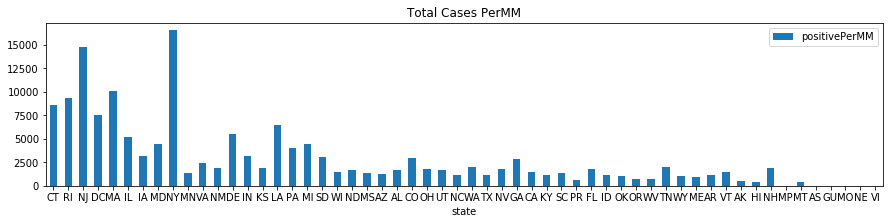

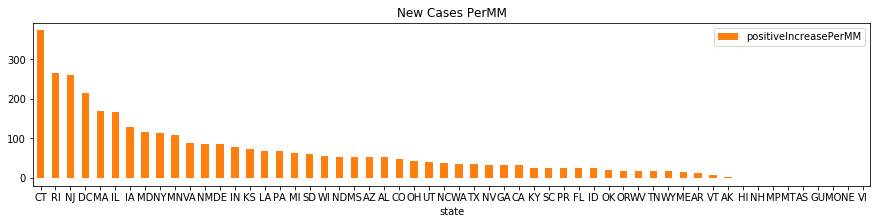

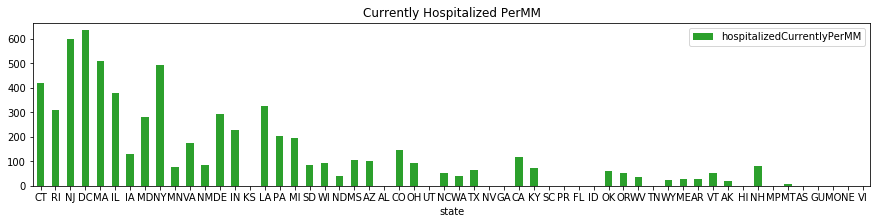

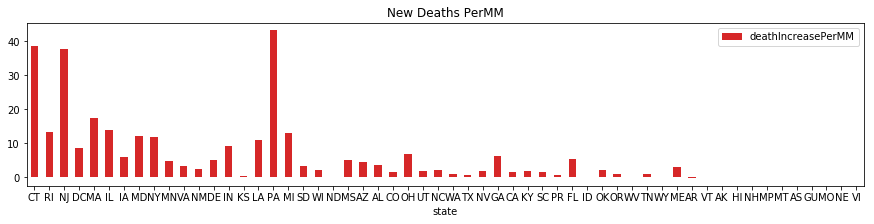

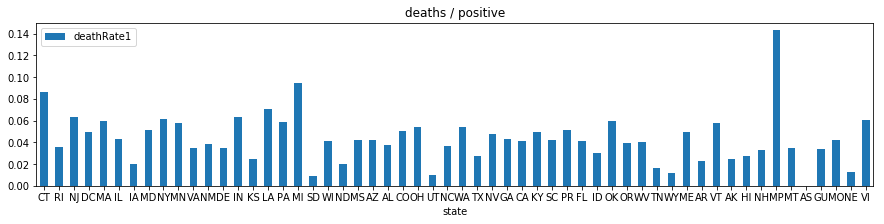

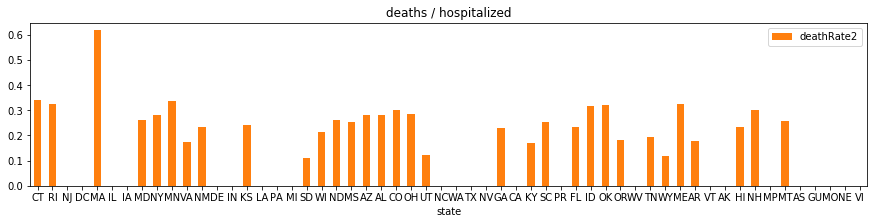

In [82]:
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='positivePerMM',rot=0,color='C0')
plt.title("Total Cases PerMM")
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='positiveIncreasePerMM',rot=0,color='C1')
plt.title("New Cases PerMM")
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='hospitalizedCurrentlyPerMM',rot=0,color='C2')
plt.title("Currently Hospitalized PerMM")
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathIncreasePerMM',rot=0,color='C3')
plt.title("New Deaths PerMM")
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathRate1',rot=0,color='C0')
plt.title("deaths / positive")
df_today.sort_values(by='positiveIncreasePerMM',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathRate2',rot=0,color='C1')
plt.title("deaths / hospitalized")


## Worst Death Rate by State
    deaths / positive and deaths / hospitalized

Text(0.5, 1.0, 'deaths / hospitalized')

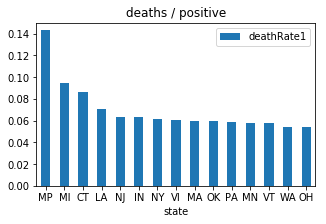

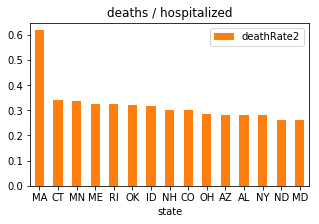

In [83]:
df_today.sort_values(by='deathRate1',ascending=False).head(15).plot.bar(figsize=(5,3),x='state',y='deathRate1',rot=0,color='C0')
plt.title("deaths / positive")
df_today.sort_values(by='deathRate2',ascending=False).head(15).plot.bar(figsize=(5,3),x='state',y='deathRate2',rot=0,color='C1')
plt.title("deaths / hospitalized")


## Best States

Text(0.5, 1.0, 'deaths / hospitalized')

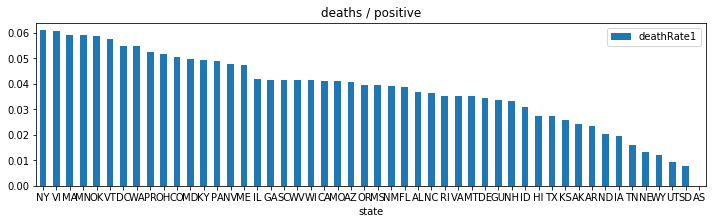

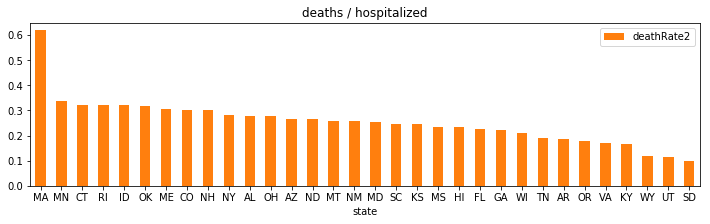

In [66]:
df_today.sort_values(by='deathRate1',ascending=False).tail(50).plot.bar(figsize=(12,3),x='state',y='deathRate1',rot=0,color='C0')
plt.title("deaths / positive")
df_today.sort_values(by='deathRate2',ascending=False).dropna(subset=['deathRate2']).tail(50).plot.bar(figsize=(12,3),x='state',y='deathRate2',rot=0,color='C1')
plt.title("deaths / hospitalized")

## 

## View data for specified state

In [46]:
n=10
the_state='TN'

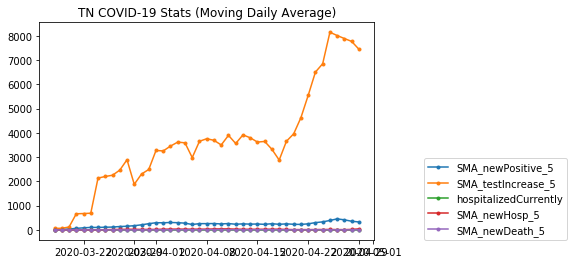

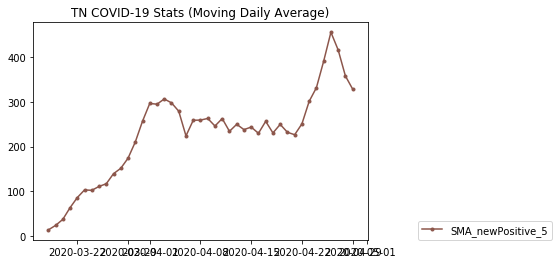

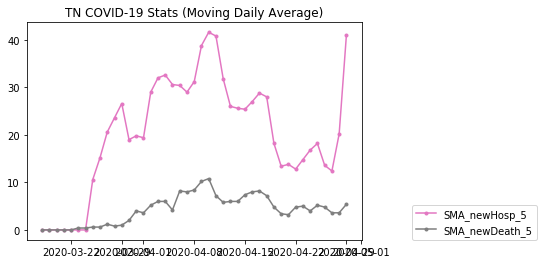

In [47]:
#mpl.style.use('default')

state_order=df_today.sort_values(by='positiveIncrease',ascending=False)['state']
i=1
for state in state_order:
    if state !=the_state:
        continue
    try:
        df_tmp = df[df['state']==state]
        startdate=20200317
        df_filtered = df_tmp[df_tmp['date']>startdate]
        df_filtered = df_filtered.fillna(0)
        if len(df_filtered)<1:
            print("No Data for: "+state) 
            continue

        plt.figure()
        #for field in ['SMA_testIncrease_5','SMA_newPositive_5','SMA_newHosp_5','SMA_newDeath_5']:
        #    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
        #plt.legend()
        #plt.title(state+" COVID-19 Stats (Moving Daily Average)")

            
        #fig, ax1 = plt.subplots()
        #ax2 = ax1.twinx()
        
        ci=0
        for field in ['SMA_newPositive_5','SMA_testIncrease_5','hospitalizedCurrently','SMA_newHosp_5','SMA_newDeath_5']:
            plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field,color='C'+str(ci))
            ci+=1
            
        plt.legend(loc=(1.15,0))
        plt.title(state+" COVID-19 Stats (Moving Daily Average)")
        
        plt.figure()
        for field in ['SMA_newPositive_5']:
            plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field,color='C'+str(ci))
            ci+=1
            
        plt.legend(loc=(1.15,0))
        plt.title(state+" COVID-19 Stats (Moving Daily Average)")
        
        plt.figure()
        for field in ['SMA_newHosp_5','SMA_newDeath_5']:
            plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field,color='C'+str(ci))
            ci+=1
            
        plt.legend(loc=(1.15,0))
        plt.title(state+" COVID-19 Stats (Moving Daily Average)")
        
        #plt.figure()
        #for field in ['percentNewPositive','percentNewHospOfPositive','percentNewHospOfTotal']:
        #    plt.plot(df_filtered['Date'],df_filtered[field],'.-',label=field)
        #    plt.title(state+' COVID-19 rates')
        #    plt.legend()

    except:
        print("ERROR: "+state) 
    
    i+=1
    if i>n:
        break

In [14]:
sum(df_today['death'].fillna(0))/sum(df_today['positive'].fillna(0))

0.0522329135474427

# Worst States

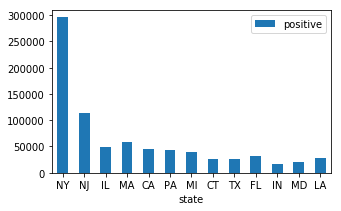

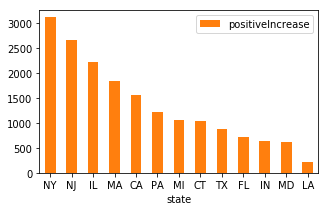

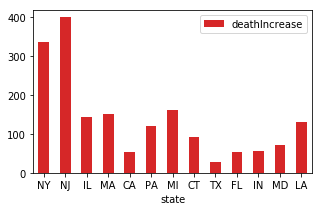

In [15]:
states_total = list(df_today.sort_values(by='positive',ascending=False).head(10)['state'])
states_inc = list(df_today.sort_values(by='positiveIncrease',ascending=False).head(10)['state'])
states_death = list(df_today.sort_values(by='deathIncrease',ascending=False).head(10)['state'])
states_watch = states_total + states_inc + states_death

df_today_w = df_today[df_today['state'].apply(lambda s: s in states_watch)]

df_today_w.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(5,3),x='state',y='positive',rot=0,color='C0')
df_today_w.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(5,3),x='state',y='positiveIncrease',rot=0,color='C1')
#df_today.sort_values(by='positiveIncrease',ascending=False).head(10).plot.bar(figsize=(5,3),x='state',y='hospitalizedCurrently',rot=0,color='C2')
df_today_w.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(5,3),x='state',y='deathIncrease',rot=0,color='C3')

## All States

Text(0.5, 1.0, 'deaths / hospitalized')

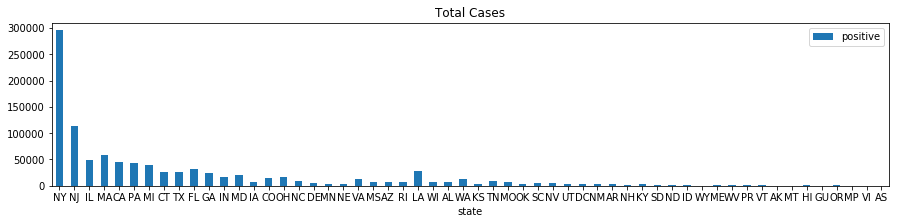

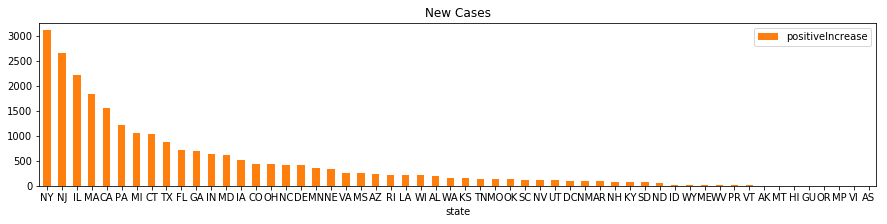

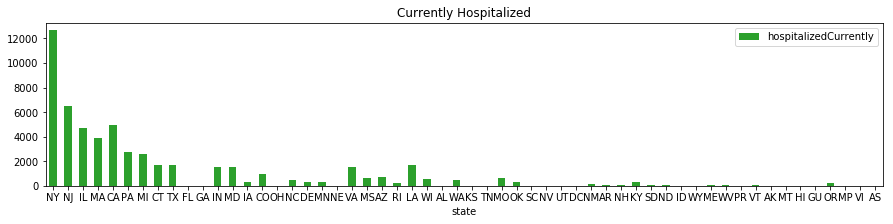

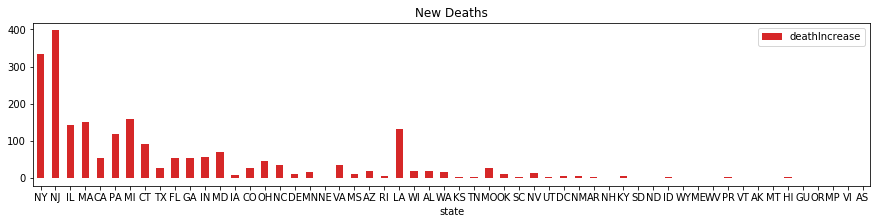

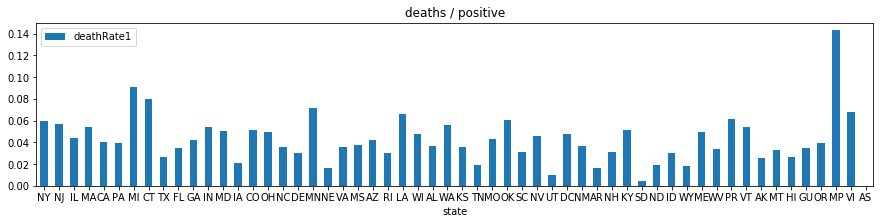

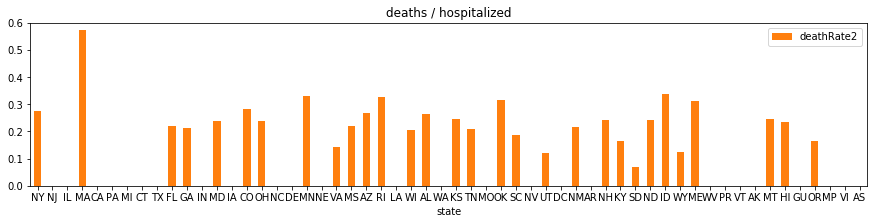

In [16]:
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='positive',rot=0,color='C0')
plt.title("Total Cases")
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='positiveIncrease',rot=0,color='C1')
plt.title("New Cases")
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='hospitalizedCurrently',rot=0,color='C2')
plt.title("Currently Hospitalized")
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathIncrease',rot=0,color='C3')
plt.title("New Deaths")
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathRate1',rot=0,color='C0')
plt.title("deaths / positive")
df_today.sort_values(by='positiveIncrease',ascending=False).plot.bar(figsize=(15,3),x='state',y='deathRate2',rot=0,color='C1')
plt.title("deaths / hospitalized")
